In [1]:
! pip install pypdf2
# Import necessary libraries
import pandas as pd
import re
import spacy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import joblib
import re
from transformers import InputExample, InputFeatures
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from tqdm import tqdm
import torch

# Load dataset
try:
    resume_data = pd.read_csv("Resume.csv")
    print("Dataset loaded successfully:")
    print(resume_data.head())
except FileNotFoundError:
    print("Error: Resume.csv not found. Please upload the file.")
    exit()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 13.9 MB/s eta 0:00:00
Dataset loaded successfully:
         ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR  


In [2]:
resume_data["Category"].value_counts()

,count
Category,
INFORMATION-TECHNOLOGY,120
BUSINESS-DEVELOPMENT,120
ADVOCATE,118
CHEF,118
ENGINEERING,118
ACCOUNTANT,118
FINANCE,118
FITNESS,117
AVIATION,117


In [3]:
# Define category mapping to 3 super-categories
category_mapping = {
    'HR': 'Business & Management',
    'DESIGNER': 'Creative & Services',
    'INFORMATION-TECHNOLOGY': 'Technology & Engineering',
    'TEACHER': 'Social & Education',
    'ADVOCATE': 'Creative & Services',
    'BUSINESS-DEVELOPMENT': 'Business & Management',
    'HEALTHCARE': 'Social & Education',
    'FITNESS': 'Social & Education',
    'AGRICULTURE': 'Social & Education',
    'BPO': 'Creative & Services',
    'SALES': 'Creative & Services',
    'CONSULTANT': 'Business & Management',
    'DIGITAL-MEDIA': 'Technology & Engineering',
    'AUTOMOBILE': 'Technology & Engineering',
    'CHEF': 'Creative & Services',
    'FINANCE': 'Business & Management',
    'APPAREL': 'Creative & Services',
    'ENGINEERING': 'Technology & Engineering',
    'ACCOUNTANT': 'Business & Management',
    'CONSTRUCTION': 'Creative & Services',
    'PUBLIC-RELATIONS': 'Business & Management',
    'BANKING': 'Business & Management',
    'ARTS': 'Creative & Services',
    'AVIATION': 'Creative & Services'
}

resume_data['Super_Category'] = resume_data['Category'].map(category_mapping)

In [4]:
# Preprocessing Functions
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    """
    Clean and normalize text by:
    - Converting to lowercase
    - Removing URLs
    - Removing email addresses
    - Removing special characters (keeping basic punctuation)
    - Removing extra whitespace
    - Handling empty strings
    - Normalizing unicode characters
    """
    if not isinstance(text, str) or not text.strip():
        return ""
    # Normalize unicode (convert fancy quotes to standard, etc.)
    text = text.encode('ascii','ignore').decode('ascii')
    text = text.lower()
    # Remove URLs and email addresses
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

In [5]:
# Apply preprocessing
resume_data['cleaned_text'] = resume_data['Resume_str'].apply(clean_text)

**DistilBERT-Based transformer model classification**



In [6]:
# Encode labels
label_encoder = LabelEncoder()
resume_data['encoded_labels'] = label_encoder.fit_transform(resume_data['Super_Category'])

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    resume_data['cleaned_text'], resume_data['encoded_labels'],
    test_size=0.15, random_state=42
)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

In [7]:
# Create PyTorch Dataset
class ResumeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [8]:
# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
MAX_LENGTH = 128
BATCH_SIZE = 16

# Create datasets
train_dataset = ResumeDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = ResumeDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)
test_dataset = ResumeDataset(test_texts, test_labels, tokenizer, MAX_LENGTH)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [9]:
# Initialize model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(label_encoder.classes_)
)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Training setup
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [11]:
# Training function
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss = 0

    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_loss / len(data_loader)

# Evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    return {
        'loss': total_loss / len(data_loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': confusion_matrix(true_labels, predictions)
    }


In [12]:
# Training loop
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)
    print(f"Train loss: {train_loss:.4f}")

    val_metrics = eval_model(model, val_loader, device)
    print(f"Validation metrics: {val_metrics}")

    # Save best model
    if val_metrics['accuracy'] > best_accuracy:
        best_accuracy = val_metrics['accuracy']
        torch.save(model.state_dict(), 'best_distilbert_model.pth')

# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_distilbert_model.pth'))
test_metrics = eval_model(model, test_loader, device)

Epoch 1/3


Training: 100%|██████████| 106/106 [00:52<00:00,  2.03it/s]


Train loss: 1.0577


Evaluating: 100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


Validation metrics: {'loss': 0.639492706016258, 'accuracy': 0.7919621749408984, 'precision': 0.7993078574306689, 'recall': 0.7919621749408984, 'f1': 0.792791315685894, 'confusion_matrix': array([[111,  19,   3,   7],
       [  4, 117,  15,   7],
       [  4,  18,  53,   3],
       [  2,   4,   2,  54]])}
Epoch 2/3


Training: 100%|██████████| 106/106 [00:30<00:00,  3.50it/s]


Train loss: 0.5277


Evaluating: 100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


Validation metrics: {'loss': 0.4897186480186604, 'accuracy': 0.8368794326241135, 'precision': 0.8373529593637475, 'recall': 0.8368794326241135, 'f1': 0.8361374360141977, 'confusion_matrix': array([[128,   4,   2,   6],
       [  3, 119,  12,   9],
       [  8,  13,  54,   3],
       [  3,   4,   2,  53]])}
Epoch 3/3


Training: 100%|██████████| 106/106 [00:39<00:00,  2.66it/s]


Train loss: 0.3991


Evaluating: 100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


Validation metrics: {'loss': 0.45978170771289756, 'accuracy': 0.83451536643026, 'precision': 0.8365084834022997, 'recall': 0.83451536643026, 'f1': 0.8341517331828939, 'confusion_matrix': array([[124,  10,   0,   6],
       [  3, 122,  12,   6],
       [  5,  16,  54,   3],
       [  2,   5,   2,  53]])}


Evaluating: 100%|██████████| 24/24 [00:08<00:00,  2.97it/s]


In [13]:
print("\nFinal Test Metrics:")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1-Score: {test_metrics['f1']:.4f}")
print("Confusion Matrix:")
print(test_metrics['confusion_matrix'])


Final Test Metrics:
Accuracy: 0.8391
Precision: 0.8358
Recall: 0.8391
F1-Score: 0.8364
Confusion Matrix:
[[ 99   7   2   0]
 [  6 130   7   7]
 [  6  12  31   3]
 [  4   3   3  53]]


* Vectorization, spliting, classifing data with lr_model and dt_model

In [14]:
# Text Vectorization for Traditional Models
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(resume_data['cleaned_text'])
y = resume_data['Super_Category']

In [15]:
# Data Split with K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kfold.split(X_tfidf):
    X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_train_tfidf, y_train, test_size=0.2, random_state=42)
    break  # Use first fold for simplicity

In [16]:
# Traditional Models with Regularization
lr_model = LogisticRegression(max_iter=1000, random_state=42, C=1.0, penalty='l2')
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5)

In [17]:
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [18]:
dt_model.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42)

In [19]:
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_dt = dt_model.predict(X_test_tfidf)

# Evaluation Metrics for Traditional Models
print("\nLogistic Regression Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_lr, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_lr, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

print("\nDecision Tree Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_dt, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_dt, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


Logistic Regression Metrics:
Accuracy: 0.7585513078470825
Precision: 0.756806600268902
Recall: 0.7585513078470825
F1-Score: 0.7556182473649439
Confusion Matrix:
 [[126  16   2   9]
 [ 12 161  15   9]
 [  8  21  37   3]
 [  6  19   0  53]]

Decision Tree Metrics:
Accuracy: 0.6579476861167002
Precision: 0.6792670658094911
Recall: 0.6579476861167002
F1-Score: 0.6491105176809229
Confusion Matrix:
 [[ 95  48   4   6]
 [ 16 167   6   8]
 [  7  27  31   4]
 [  5  38   1  34]]


In [20]:
# Bi-LSTM Model
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(resume_data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(resume_data['cleaned_text'])
X_padded = pad_sequences(sequences, maxlen=max_len)

In [21]:
X_train_blstm, X_test_blstm, y_train_blstm, y_test_blstm = train_test_split(X_padded, y, test_size=0.15, random_state=42)
X_train_blstm, X_val_blstm, y_train_blstm, y_val_blstm = train_test_split(X_train_blstm, y_train_blstm, test_size=0.2, random_state=42)

In [22]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_blstm)
y_test_encoded = le.transform(y_test_blstm)
y_val_encoded = le.transform(y_val_blstm)

In [23]:
blstm_model = Sequential()
blstm_model.add(Embedding(max_words, 100, input_length=max_len))
blstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
blstm_model.add(Dropout(0.3))  # Increased dropout
blstm_model.add(Bidirectional(LSTM(32)))
blstm_model.add(Dropout(0.3))  # Increased dropout
blstm_model.add(Dense(len(le.classes_), activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
blstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
blstm_model.fit(X_train_blstm, y_train_encoded, validation_data=(X_val_blstm, y_val_encoded), epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.3867 - loss: 1.3318 - val_accuracy: 0.5390 - val_loss: 1.1189
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6003 - loss: 0.9954 - val_accuracy: 0.6217 - val_loss: 0.9444
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8027 - loss: 0.5672 - val_accuracy: 0.5745 - val_loss: 1.1659
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9210 - loss: 0.2994 - val_accuracy: 0.5603 - val_loss: 1.2071
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9704 - loss: 0.1282 - val_accuracy: 0.5556 - val_loss: 1.5787


In [25]:
y_pred_blstm = np.argmax(blstm_model.predict(X_test_blstm), axis=1)
y_pred_blstm = le.inverse_transform(y_pred_blstm)

# Evaluation Metrics for Bi-LSTM
print("\nBi-LSTM Metrics:")
print("Accuracy:", accuracy_score(y_test_blstm, y_pred_blstm))
print("Precision:", precision_score(y_test_blstm, y_pred_blstm, average='weighted'))
print("Recall:", recall_score(y_test_blstm, y_pred_blstm, average='weighted'))
print("F1-Score:", f1_score(y_test_blstm, y_pred_blstm, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test_blstm, y_pred_blstm))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

Bi-LSTM Metrics:
Accuracy: 0.5871313672922251
Precision: 0.5748658020874755
Recall: 0.5871313672922251
F1-Score: 0.5634287710610654
Confusion Matrix:
 [[ 80  22   1   5]
 [ 26 109  10   5]
 [ 15  26   9   2]
 [ 23  14   5  21]]



Model Performance Comparison:


,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.758551,0.756807,0.758551,0.755618
Decision Tree,0.657948,0.679267,0.657948,0.649111
Bi-LSTM,0.587131,0.574866,0.587131,0.563429
DistilBERT,0.839142,0.835796,0.839142,0.836376


Visualizing Model Accuracy Comparison:


/tmp/ipython-input-3682356051.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df['Accuracy'], palette='viridis')


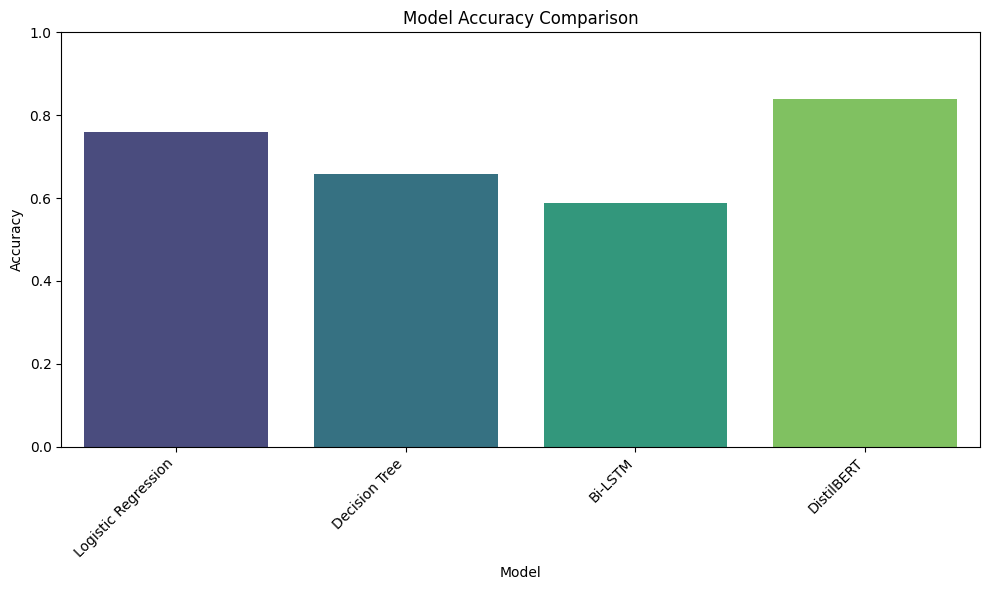

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collect metrics
metrics = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, y_pred_lr),
        'Precision': precision_score(y_test, y_pred_lr, average='weighted'),
        'Recall': recall_score(y_test, y_pred_lr, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred_lr, average='weighted')
    },
    'Decision Tree': {
        'Accuracy': accuracy_score(y_test, y_pred_dt),
        'Precision': precision_score(y_test, y_pred_dt, average='weighted'),
        'Recall': recall_score(y_test, y_pred_dt, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred_dt, average='weighted')
    },
    'Bi-LSTM': {
        'Accuracy': accuracy_score(y_test_blstm, y_pred_blstm),
        'Precision': precision_score(y_test_blstm, y_pred_blstm, average='weighted'),
        'Recall': recall_score(y_test_blstm, y_pred_blstm, average='weighted'),
        'F1-Score': f1_score(y_test_blstm, y_pred_blstm, average='weighted')
    },
    'DistilBERT': {
        'Accuracy': test_metrics['accuracy'],
        'Precision': test_metrics['precision'],
        'Recall': test_metrics['recall'],
        'F1-Score': test_metrics['f1']
    }
}

# Display metrics in a pandas DataFrame for easy comparison
metrics_df = pd.DataFrame(metrics).T
print("\nModel Performance Comparison:")
display(metrics_df)

print("Visualizing Model Accuracy Comparison:")

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_df.index, y=metrics_df['Accuracy'], palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [27]:
# Predict the category of a new resume using the best-performing model
new_resume_text = """
Experienced software engineer with a strong background in Python and machine learning.
Skilled in developing and deploying scalable applications.
Bachelor's degree in Computer Science.
"""
# Cleaning new resume text using the defined function
cleaned_new_resume_text = clean_text(new_resume_text)
print(f"Cleaned new resume text: {cleaned_new_resume_text}")

# Re-initialize the DistilBertTokenizer to ensure we are using the correct one
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

MAX_LENGTH = 512
new_resume_encoding = distilbert_tokenizer(
    cleaned_new_resume_text,
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Make prediction with PyTorch
with torch.no_grad():
    input_ids = new_resume_encoding['input_ids'].to(device)
    attention_mask = new_resume_encoding['attention_mask'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_class_index = torch.argmax(logits, dim=1).item()

# Inverse transform the predicted class to the original category name
predicted_category = label_encoder.inverse_transform([predicted_class_index])[0]
print(f"\nPredicted Category for the new resume: {predicted_category}")

Cleaned new resume text: experienced software engineer with a strong background in python and machine learning skilled in developing and deploying scalable applications bachelors degree in computer science

Predicted Category for the new resume: Technology & Engineering


In [28]:
import os

# ------------------------------------------------------------------
# 1. Save model & tokenizer
# ------------------------------------------------------------------
save_dir = "distilbert_resume_classifier"
os.makedirs(save_dir, exist_ok=True)

model.save_pretrained(save_dir)                  # saves config + pytorch_model.bin
distilbert_tokenizer.save_pretrained(save_dir)              # saves vocab.txt + tokenizer.json
print(f"✅ Model & tokenizer saved to ./{save_dir}")

# ------------------------------------------------------------------
# 2. Save label encoder so the app knows the mapping
# ------------------------------------------------------------------
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.pkl"))
print("✅ Label encoder saved")

✅ Model & tokenizer saved to ./distilbert_resume_classifier
✅ Label encoder saved
